In [1]:
# Call libraries
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio as rio
import earthpy.plot as ep
import earthpy.spatial as es

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint
from osgeo import gdal, gdal_array

In [7]:
# Load data
dat2012 = pd.read_csv("field2012_clean.csv", sep = ',').drop(['Unnamed: 0'], axis = 1)
dat2012.head()

,Experiment_Id,SP_ID,sample_distance (m),Year,Field,Sample_date,Sample_time,Easting,Northing,pH,BD_gcm3,OM_%w/w,N_total_%w/w,C_total_%w/w,geometry
0,FP003,1,50,2012,Pecketsford,2012-06-06,12:00:00,265632,99300,5.18,0.916,10.1,0.51,4.742,POINT (265632 99300)
1,FP003,2,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99275,5.23,0.943,10.4,0.55,4.980,POINT (265625 99275)
2,FP003,7,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99225,5.54,0.948,11.8,0.64,5.610,POINT (265575 99225)
3,FP003,9,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99225,5.12,0.857,10.9,0.54,4.510,POINT (265625 99225)
4,FP003,17,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99175,5.68,0.946,11.5,0.59,5.340,POINT (265575 99175)


In [6]:
dat2012.dropna(inplace = True)
dat2012.head()

,Experiment_Id,SP_ID,sample_distance (m),Year,Field,Sample_date,Sample_time,Easting,Northing,pH,BD_gcm3,OM_%w/w,N_total_%w/w,C_total_%w/w,geometry,CStock_kgm2
0,FP003,1,50,2012,Pecketsford,2012-06-06,12:00:00,265632,99300,5.18,0.916,10.1,0.51,4.742,POINT (265632 99300),9.990446
1,FP003,2,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99275,5.23,0.943,10.4,0.55,4.980,POINT (265625 99275),10.801122
2,FP003,7,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99225,5.54,0.948,11.8,0.64,5.610,POINT (265575 99225),12.232044
3,FP003,9,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99225,5.12,0.857,10.9,0.54,4.510,POINT (265625 99225),8.889661
4,FP003,17,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99175,5.68,0.946,11.5,0.59,5.340,POINT (265575 99175),11.618772


In [8]:
dat2012['CStock_kgm2'] = (dat2012['C_total_%w/w']* 10) * dat2012['BD_gcm3'] * 0.23
dat2012.head()

,Experiment_Id,SP_ID,sample_distance (m),Year,Field,Sample_date,Sample_time,Easting,Northing,pH,BD_gcm3,OM_%w/w,N_total_%w/w,C_total_%w/w,geometry,CStock_kgm2
0,FP003,1,50,2012,Pecketsford,2012-06-06,12:00:00,265632,99300,5.18,0.916,10.1,0.51,4.742,POINT (265632 99300),9.990446
1,FP003,2,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99275,5.23,0.943,10.4,0.55,4.980,POINT (265625 99275),10.801122
2,FP003,7,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99225,5.54,0.948,11.8,0.64,5.610,POINT (265575 99225),12.232044
3,FP003,9,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99225,5.12,0.857,10.9,0.54,4.510,POINT (265625 99225),8.889661
4,FP003,17,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99175,5.68,0.946,11.5,0.59,5.340,POINT (265575 99175),11.618772


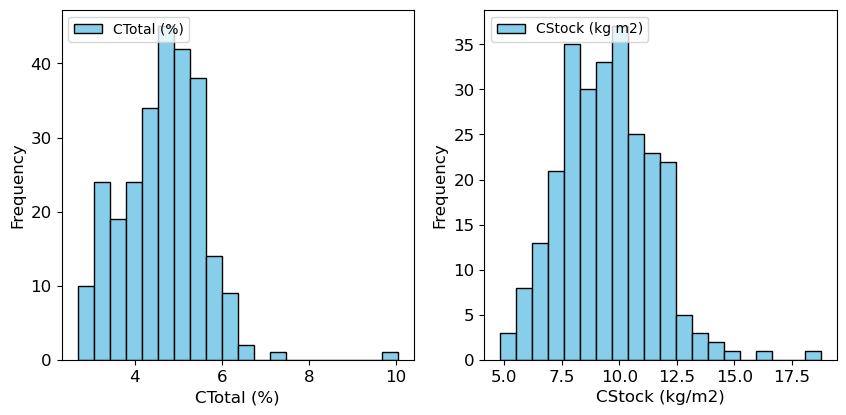

In [10]:
# Plot
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
ax = plt.gca()
plt.hist(dat2012['C_total_%w/w'], bins = 20, ec = 'black', color = 'skyblue', label = 'CTotal (%)')
plt.legend(loc='upper left')
plt.xlabel('CTotal (%)', fontsize = 12)
plt.tick_params(labelsize=12)
plt.ylabel('Frequency', fontsize = 12)


plt.subplot(2,2,2)
ax = plt.gca()
plt.hist(dat2012['CStock_kgm2'], bins = 20, ec = 'black', color = 'skyblue', label = 'CStock (kg m2)')
plt.legend(loc='upper left')
plt.xlabel('CStock (kg/m2)', fontsize = 12)
plt.tick_params(labelsize=12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

In [15]:
## Create list with rasters
## Names: B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, NDVI, NDRE, GNDVI, NDMI, EVI, BSI, 
## DEM, ASPECT, CONVERGENCI INDEX, LS FACTOR, PLAN CURVATURE, RELATIVE SLOPE POSITION,
## SLOPE, TOPOGRAPHIC WETNESS INDEX
#dem = 'C:/Users/neliq/Documents/NIF/Rothamsted/5.satellites_images/DEM_terrain/DEM_5m.tif'
#terrain = 'C:/Users/neliq/Documents/NIF/Rothamsted/5.satellites_images/DEM_terrain/terrain_crop_5m.tif'
##S2A = 'C:/Users/neliq/Documents/NIF/Rothamsted/5.satellites_images/Sentinel/5m/S2A_july_5m.tif'
path_covs = 'C:/Users/neliq/Documents/NIF/Rothamsted/5.satellites_images/Landsat/5m/L8DEMTerrain2013.tif'
#list_raster = [S2A, dem, terrain]
#list_raster

In [37]:
# Create a raster stack with all rasters and save
covs_stack, covs_meta = es.stack(list_raster,
                                 path_covs)

In [16]:
# Open the new raster
covs = rio.open(path_covs)
covs.shape

(428, 463)

In [19]:
# Extract raster values
dat2012.index = range(len(dat2012))
coords = [(x,y) for x, y in zip(dat2012.Easting, dat2012.Northing)]
dat2012['ju'] = [x for x in covs.sample(coords)]
dat2012.head()

,Experiment_Id,SP_ID,sample_distance (m),Year,Field,Sample_date,Sample_time,Easting,Northing,pH,BD_gcm3,OM_%w/w,N_total_%w/w,C_total_%w/w,geometry,CStock_kgm2,ju
0,FP003,1,50,2012,Pecketsford,2012-06-06,12:00:00,265632,99300,5.18,0.916,10.1,0.51,4.742,POINT (265632 99300),9.990446,"[8497.0, 9509.0, 8752.0, 22399.0, 13959.0, 106..."
1,FP003,2,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99275,5.23,0.943,10.4,0.55,4.980,POINT (265625 99275),10.801122,"[8497.0, 9624.0, 9026.0, 20828.0, 14712.0, 108..."
2,FP003,7,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99225,5.54,0.948,11.8,0.64,5.610,POINT (265575 99225),12.232044,"[8512.0, 9842.0, 9245.0, 21434.0, 15004.0, 111..."
3,FP003,9,50,2012,Pecketsford,2012-06-06,12:00:00,265625,99225,5.12,0.857,10.9,0.54,4.510,POINT (265625 99225),8.889661,"[8454.0, 10005.0, 9176.0, 22305.0, 14819.0, 10..."
4,FP003,17,50,2012,Pecketsford,2012-06-06,12:00:00,265575,99175,5.68,0.946,11.5,0.59,5.340,POINT (265575 99175),11.618772,"[8506.0, 10136.0, 9179.0, 22945.0, 14847.0, 10..."


In [20]:
dat2012['ju']

0      [8497.0, 9509.0, 8752.0, 22399.0, 13959.0, 106...
1      [8497.0, 9624.0, 9026.0, 20828.0, 14712.0, 108...
2      [8512.0, 9842.0, 9245.0, 21434.0, 15004.0, 111...
3      [8454.0, 10005.0, 9176.0, 22305.0, 14819.0, 10...
4      [8506.0, 10136.0, 9179.0, 22945.0, 14847.0, 10...
                             ...                        
258    [9999.0, 11443.0, 12600.0, 16802.0, 18358.0, 1...
259    [9347.0, 10533.0, 11353.0, 15899.0, 15993.0, 1...
260    [9958.0, 11520.0, 12715.0, 16876.0, 18277.0, 1...
261    [9405.0, 10671.0, 11497.0, 15975.0, 16214.0, 1...
262    [9631.0, 10892.0, 11508.0, 16875.0, 16525.0, 1...
Name: ju, Length: 263, dtype: object

In [23]:
## Convert to pandas dataframe and separate the columns list
dat2012_df = pd.DataFrame(dat2012)
dat2012_split = pd.DataFrame(dat2012_df ['ju'].tolist(), columns = ["B2", "B3", "B4", "B5", "B6", "B7", 'B10',
                                                                    "NDVI", "GNDVI", "NDMI", "EVI", "BSI","DEM", 
                                                                    "ASP", "CI", "LS", "PC", "RSP", "SLP", "TWI"])
dataset_df = pd.concat([dat2012_df, dat2012_split], axis=1)
dataset_df = dataset_df.drop(['geometry', 'ju'], axis=1)  ## drop all the columns that will no be used

dataset_df.to_csv("dat2012_withcovsL8.csv", index = False)

In [24]:
xy = dataset_df[['C_total_%w/w','CStock_kgm2',"B2", "B3", "B4", "B5", "B6", "B7", 'B10', "NDVI", "GNDVI", "NDMI", 
                 "EVI", "BSI","DEM", "ASP", "CI", "LS", "PC", "RSP", "SLP", "TWI"]]
xy.corr()

,C_total_%w/w,CStock_kgm2,B2,B3,B4,B5,B6,B7,B10,NDVI,...,EVI,BSI,DEM,ASP,CI,LS,PC,RSP,SLP,TWI
C_total_%w/w,1.000000,0.899900,-0.495468,-0.357070,-0.534390,0.546694,-0.183930,-0.456501,0.344625,0.568985,...,0.554742,-0.525052,0.151034,-0.112026,0.162372,0.088513,0.182663,-0.123212,0.151185,-0.210467
CStock_kgm2,0.899900,1.000000,-0.416739,-0.284862,-0.476237,0.515630,-0.120038,-0.382621,0.307833,0.524104,...,0.515603,-0.476415,0.125469,-0.064980,0.193399,0.104688,0.220582,-0.047087,0.184851,-0.281060
B2,-0.495468,-0.416739,1.000000,0.855944,0.948288,-0.676172,0.833517,0.964371,-0.216752,-0.826056,...,-0.826428,0.863021,-0.095613,-0.048428,-0.046693,-0.252780,-0.095737,0.370086,-0.267211,0.112301
B3,-0.357070,-0.284862,0.855944,1.000000,0.835054,-0.369413,0.822859,0.832493,-0.104056,-0.584430,...,-0.647531,0.632476,-0.065024,0.023282,-0.016868,-0.140722,-0.073065,0.344280,-0.139122,0.004880
B4,-0.534390,-0.476237,0.948288,0.835054,1.000000,-0.798882,0.750613,0.956003,-0.203149,-0.926669,...,-0.947458,0.944826,-0.038685,-0.028928,-0.042955,-0.281532,-0.102744,0.391285,-0.304801,0.136807
B5,0.546694,0.515630,-0.676172,-0.369413,-0.798882,1.000000,-0.325873,-0.699994,0.234191,0.963692,...,0.932952,-0.933437,-0.038921,-0.022551,0.045451,0.267164,0.070283,-0.311369,0.299687,-0.182777
B6,-0.183930,-0.120038,0.833517,0.822859,0.750613,-0.325873,1.000000,0.872468,0.003880,-0.527335,...,-0.557144,0.635273,-0.005527,-0.175328,0.015259,-0.248598,-0.039655,0.361738,-0.238424,0.020036
B7,-0.456501,-0.382621,0.964371,0.832493,0.956003,-0.699994,0.872468,1.000000,-0.160466,-0.845372,...,-0.854726,0.895483,-0.050871,-0.109507,-0.010651,-0.305349,-0.069615,0.396927,-0.317346,0.112082
B10,0.344625,0.307833,-0.216752,-0.104056,-0.203149,0.234191,0.003880,-0.160466,1.000000,0.223887,...,0.208082,-0.186682,0.794260,-0.464531,0.248649,0.093349,0.250414,0.425211,0.186542,-0.359119
NDVI,0.568985,0.524104,-0.826056,-0.584430,-0.926669,0.963692,-0.527335,-0.845372,0.223887,1.000000,...,0.989028,-0.988261,-0.009418,0.006347,0.048176,0.286826,0.088674,-0.357961,0.317729,-0.175565


In [25]:
# Separate into X's and Y
x = dataset_df[["B2", "B3", "B4", "B5", "B6", "B7", 'B10', "NDVI", "GNDVI", "NDMI", 
                 "EVI", "BSI","DEM", "ASP", "CI", "LS", "PC", "RSP", "SLP", "TWI"]]
y = dataset_df[['C_total_%w/w']]

In [26]:
# Split dataset into training and validation
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 49, test_size = 0.3)

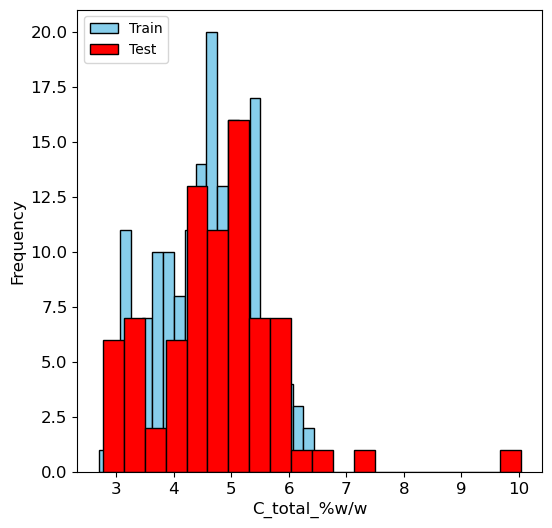

In [28]:
# Plot train and test datasets
plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.hist(y_train['C_total_%w/w'], bins = 20, ec = 'black', color = 'skyblue', label = 'Train')
plt.hist(y_test['C_total_%w/w'], bins = 20, ec = 'black', color ='red', label = 'Test')
plt.legend(loc='upper left')
plt.xlabel('C_total_%w/w', fontsize = 12)
plt.tick_params(labelsize=12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

In [52]:
# Gradient Boosting - Base model, no hyperparameter tuning
baseGB_CTotal = GradientBoostingRegressor(n_estimators = 35).fit(x_train, y_train['C_total_%w/w'])
print('The R2 of the train is {}'.format(round(baseGB_CTotal.score(x_train, y_train['C_total_%w/w']), 2)))
print('The R2 of the test is {}'.format(round(baseGB_CTotal.score(x_test, y_test['C_total_%w/w']), 2)))

The R2 of the train is 0.89
The R2 of the test is 0.36


In [32]:
# Random - Base model, no hyperparameter tuning
baseRF_CTotal = RandomForestRegressor().fit(x_train, y_train['C_total_%w/w'])
print('The R2 of the train is {}'.format(round(baseRF_CTotal.score(x_train, y_train['C_total_%w/w']), 2)))
print('The R2 of the test is {}'.format(round(baseRF_CTotal.score(x_test, y_test['C_total_%w/w']), 2)))

The R2 of the train is 0.94
The R2 of the test is 0.36


In [33]:
# Predict using Gradient boosting and RF
predCT_gb = baseGB_CTotal.predict(x_test)
predCT_rf = baseRF_CTotal.predict(x_test)

In [34]:
# Evaluate the models
def eval_model(model_gb, model_rf, features, target):
    preds_gb = model_gb.predict(features)
    preds_rf = model_rf.predict(features)
    rmse_gb = float(format(np.sqrt(mean_squared_error(target, preds_gb)), '.2f'))
    rmse_rf = float(format(np.sqrt(mean_squared_error(target, preds_rf)), '.2f'))
    print ('\nPerformances')
    print('RMSE GB CTotal = ', rmse_gb, '%')
    print('RMSE RF CTotal = ', rmse_rf, '%')

# Base GB model
eval_model(baseGB_CTotal, baseRF_CTotal, x_test, y_test['C_total_%w/w'])


Performances
RMSE GB CTotal =  0.87 %
RMSE RF CTotal =  0.88 %


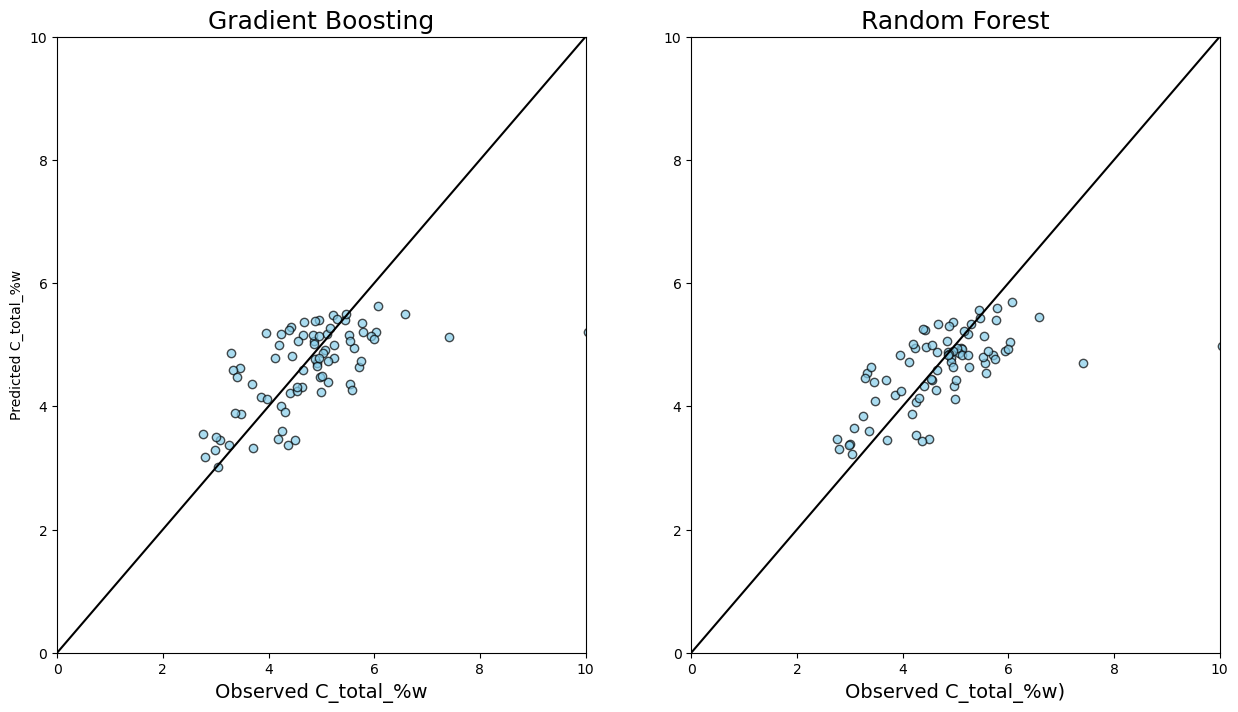

In [35]:
# Plot
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
plt.scatter(y_test['C_total_%w/w'], predCT_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 0), slope=1, color='black', label='by slope')
plt.ylabel('')
plt.xlabel('Observed C_total_%w', fontsize=14)
plt.ylabel('Predicted C_total_%w')
plt.title('Gradient Boosting', fontsize=18)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axline((0, 0), slope=1, color='black', label='by slope')
plt.scatter(y_test['C_total_%w/w'], predCT_rf, edgecolor='k', facecolor='skyblue', alpha=0.7)
plt.ylabel('')
plt.xlabel('Observed C_total_%w)', fontsize=14)
plt.title('Random Forest', fontsize=18)

#plt.savefig('predicted_vs_observed_2015-2020_gb_rf.jpeg', dpi = 300)
plt.show()

In [36]:
# Parameters of base models
print('\nParameters currently in use in GB:\n')
pprint(baseGB_CTotal.get_params())


Parameters currently in use in GB:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [60]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 500)]

# Loss
loss = ['squared_error', 'absolute_error', 'huber']

# Learning rate
learning_rate = [0.01, 0.05, 0.1, 0.2]

# Samples split
min_samples_split = [2, 4, 10, 15, 20, 50]

# Samples leaf
min_samples_leaf = [2, 4, 6, 10, 20, 50]

# Depth
max_depth = [2, 4, 6, 10, 20]

# Max features
max_features = ['auto', 'sqrt', 'log2']

# Max nodes
max_leaf_nodes = [2, 6, 10, 15, 20]

# Create the random grid
random_search_gb = {'n_estimators': n_estimators,
                    'loss': loss,
                    'learning_rate': learning_rate,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'max_depth': max_depth,
                    'max_leaf_nodes': max_leaf_nodes}

In [61]:
## Run the model with the hyperparameter tuning
gb_tuning = GradientBoostingRegressor()

gb_tuning_RSCV = RandomizedSearchCV(estimator = gb_tuning, 
                                    param_distributions = random_search_gb, 
                                    n_iter = 10, 
                                    cv = 10, 
                                    verbose = 2, 
                                    n_jobs = -1)

gb_tuning_RSCV.fit(x_train, y_train['C_total_%w/w'])

## Print the best parameters
print('\nThe best parameters are: \n')
pprint(gb_tuning_RSCV.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

The best parameters are: 

{'learning_rate': 0.2,
 'loss': 'huber',
 'max_depth': 10,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 20,
 'min_samples_split': 50,
 'n_estimators': 319}


In [62]:
# Predict onto the test set
best_random_gb = gb_tuning_RSCV.best_estimator_
pred_random_gb = best_random_gb.predict(x_test)

In [63]:
# Scores
rmse_gb = float(format(np.sqrt(mean_squared_error(y_test['C_total_%w/w'], pred_random_gb)), '.3f'))
print ('\nPerformance')
print('RMSE = ', rmse_gb, '%')

print('R2 = {}'.format(round(best_random_gb.score(x_test, y_test['C_total_%w/w']), 2)))


Performance
RMSE =  0.873 %
R2 = 0.37


In [64]:
predict_train = baseGB_CTotal.predict(x_train)
bestgrid_train = best_random_gb.predict(x_train)

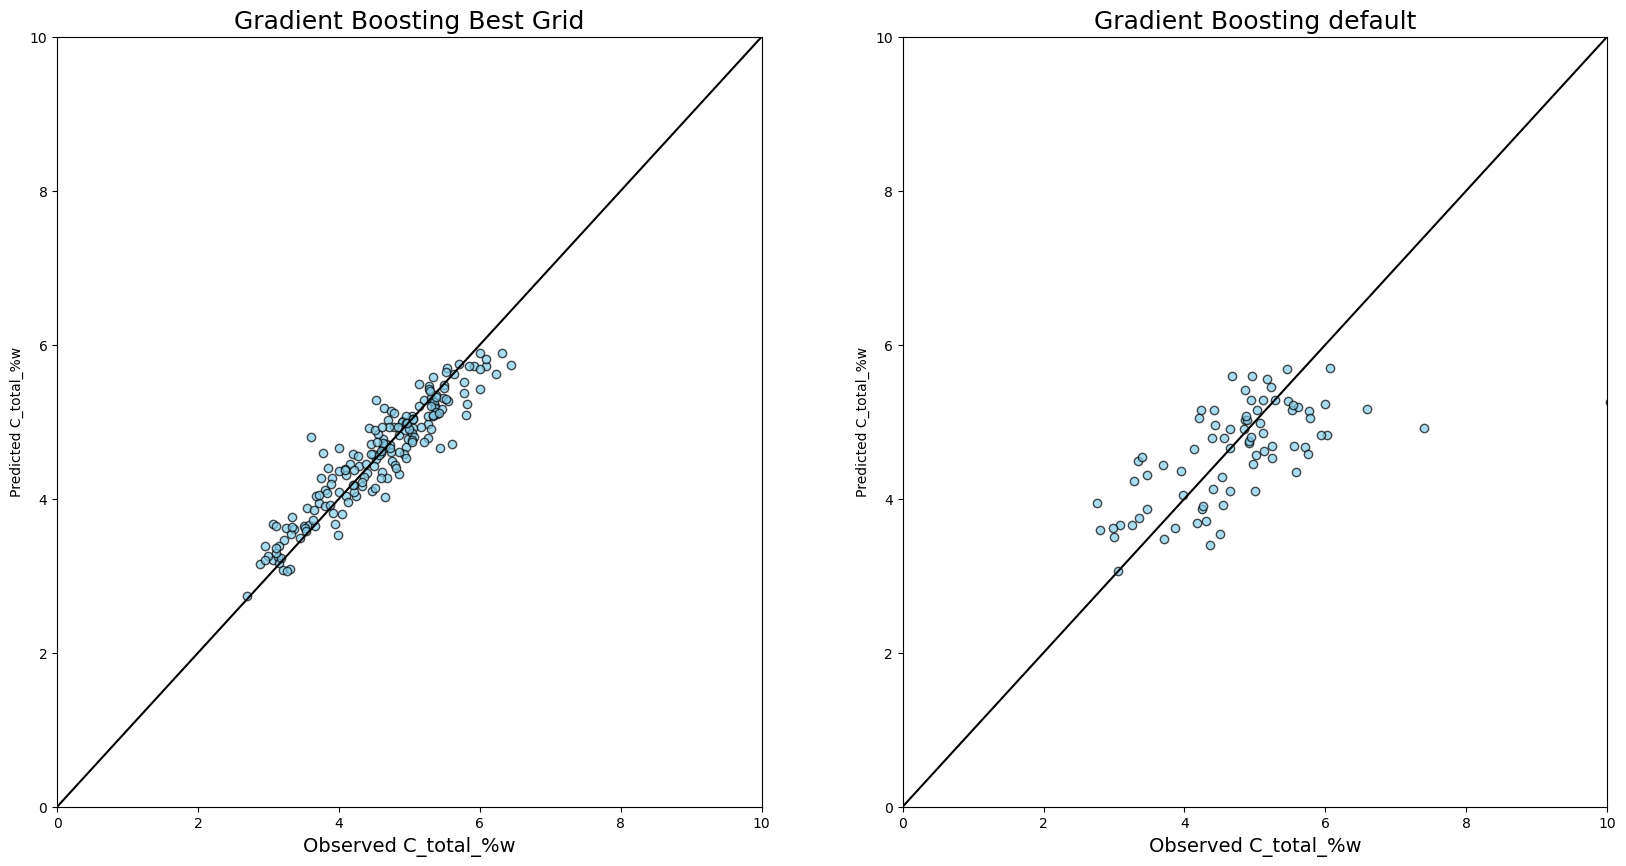

In [65]:
# Plot observed vs predicted
# Plot
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
plt.scatter(y_train['C_total_%w/w'], bestgrid_train, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 0), slope=1, color='black', label='by slope')
plt.ylabel('')
plt.xlabel('Observed C_total_%w', fontsize=14)
plt.ylabel('Predicted C_total_%w')
plt.title('Gradient Boosting Best Grid', fontsize=18)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
plt.scatter(y_test['C_total_%w/w'], pred_random_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 0), slope=1, color='black', label='by slope')
plt.ylabel('')
plt.xlabel('Observed C_total_%w', fontsize=14)
plt.ylabel('Predicted C_total_%w')
plt.title('Gradient Boosting default', fontsize=18)
plt.show()

In [66]:
# Get numerical feature importances
importance = list(baseGB_CTotal.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: B5                   Importance: 0.404
Variable: B10                  Importance: 0.153
Variable: B2                   Importance: 0.103
Variable: DEM                  Importance: 0.054
Variable: TWI                  Importance: 0.046
Variable: EVI                  Importance: 0.043
Variable: CI                   Importance: 0.029
Variable: PC                   Importance: 0.027
Variable: NDVI                 Importance: 0.024
Variable: RSP                  Importance: 0.022
Variable: LS                   Importance: 0.018
Variable: B6                   Importance: 0.017
Variable: ASP                  Importance: 0.015
Variable: B4                   Importance: 0.013
Variable: B3                   Importance: 0.011
Variable: B7                   Importance: 0.009
Variable: GNDVI                Importance: 0.007
Variable: NDMI                 Importance: 0.003
Variable: SLP                  Importance: 0.003
Variable: BSI                  Importance: 0.001


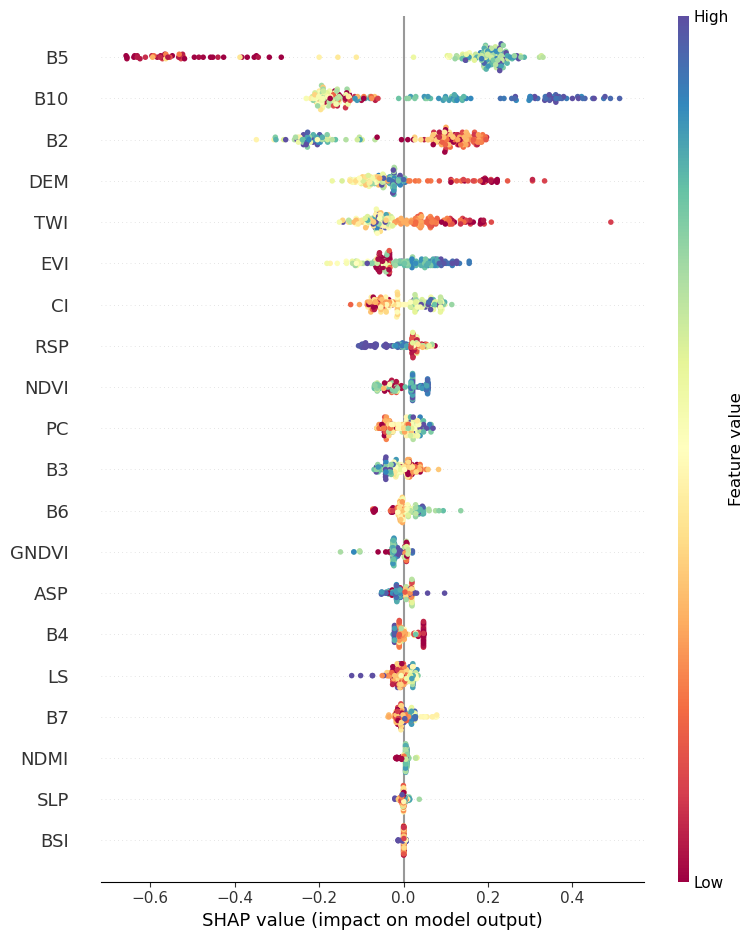

In [67]:
import shap
## Shapley values to explain RF models
explainer = shap.TreeExplainer(baseGB_CTotal)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, features = x_train, feature_names = x_train.columns, cmap = 'Spectral')

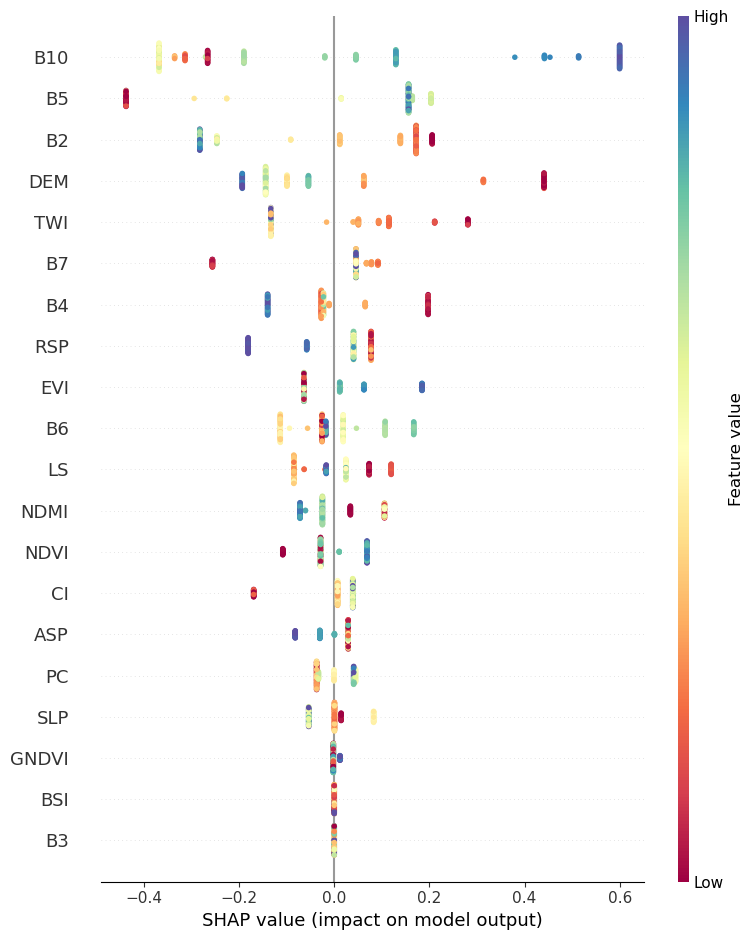

In [69]:
import shap
## Shapley values to explain RF models
explainer = shap.TreeExplainer(best_random_gb)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, features = x_train, feature_names = x_train.columns, cmap = 'Spectral')

In [73]:
## load image data
img_RS = 'C:/Users/neliq/Documents/NIF/Rothamsted/5.satellites_images/Landsat/5m/L8DEMTerrain2013.tif'

image = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((image.RasterYSize, image.RasterXSize, image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(image.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = image.GetRasterBand(b + 1).ReadAsArray()
    

## Set the number of columns, rows and bands
rows = image.RasterXSize
cols = image.RasterYSize
bands = image.RasterCount

print('Image extent: {} x {} (row x col)'.format(rows, cols))
print('Number of Bands: {}'.format(bands))

Image extent: 463 x 428 (row x col)
Number of Bands: 20


In [74]:
## Reshape to (row*col, bands)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)
img_as_array.shape

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(198164, 20)

In [75]:
## Predicting into the entire raster
soc_prediction = best_random_gb.predict(img_as_array)
soc_prediction = soc_prediction.reshape(img[:, :, 0].shape)
soc_prediction.shape

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


(428, 463)

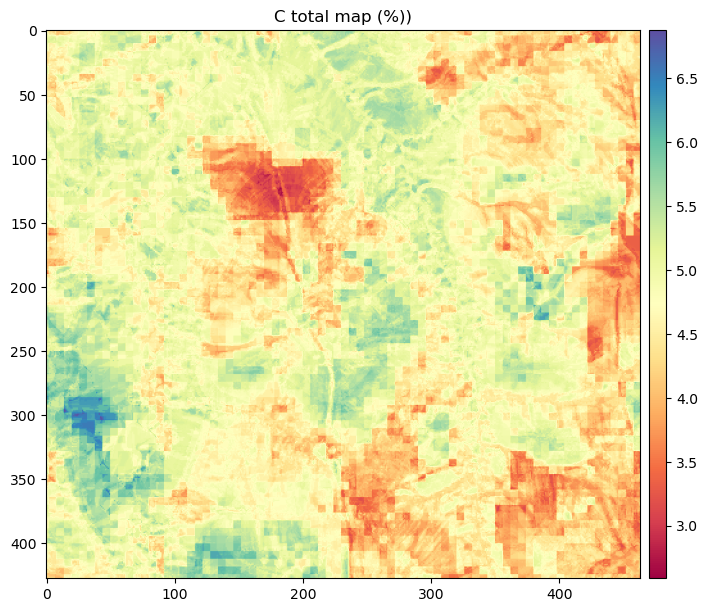

In [76]:
## Plotting the predicted map
fig, axs = plt.subplots(figsize=(8,8))
img = axs.imshow(soc_prediction, cmap = 'Spectral')
plt.title("C total map (%))")
cbar = ep.colorbar(img)
plt.show()

In [152]:
## Load raster
with rio.open('C:/Users/neliq/Documents/NIF/Rothamsted/5.satellites_images/S2ADem_TerrainR.tif') as covs:
    covs_array = covs.read()
    covs_meta = covs.profile
    covs_affine = covs.profile.pop('transform')
covs_array.shape

(24, 428, 463)

In [156]:
# Export raster
soc_new = soc_prediction.reshape(1, 428, 463)
with rio.open('CTotalS2A_2016_5m_TEST.tif', 'w', 
              driver = 'GTiff', 
              height = soc_prediction.shape[1], 
              width = soc_prediction.shape[0],
              count = 1,
              dtype = soc_prediction.dtype,
              transform = covs_affine) as dst:
    dst.write(soc_new)